# Linking field data from CORE to DBLP data

* CORE contains for each journal and proceedings a ranking and a field
* however the fields are just codes, and I do not know the corresponding names yet
    * Note that the orginal field names are fucked up by pandas: 0806 becomes 806.0, etc
    
* Using a bit of handtweaking we could match all of the 64 A* CORE conferences to DBLP conference acronyms


## Result
* Dataframe  'Data/AstarCandJ.pkl' with 750K rows from DBLP with additional
    * gender
    * field
    * These are all A* journals and conferences from CORE that could be matched with a DBLP conf or journal


## Watch out

* DBLP uses the same acronym for a journal and for a conference (e.g. sigmod for sigmod conference and sigmod record)
* Thus always make a selection to conference or journal before you join.



## Todo, manual tuning

### Conf
* All 64 A* confs from CORE are matched to DBLP conferences
* We end up with this many publication-author pairs from these 64 A* conferences, which are grouped into 7 groups.
```
male       334959
female      82674
unknown     61170
```

#### A and A*
* If we consider A and A*, we stil need to match 50 acronyms, but without those 50 we already have 3 times as many pub-author pairs. We then get 8 groups with a size of at least 10 conferences.
```
male       941369
female     233245
unknown    180227
```

### Journal

* All journals need to be hand matched it seems, but it is relatively easy I think
* Maybe we can do an automatic search...
* 60 A* and 149 A.... Still some work.....

#### first try on the 60A* ones
* 10 journals matched by simply lowercasing
* 17 ACM and IEEE matched (hopefully correct) of the 22 ACM and IEEE

In [2]:
import pandas as pd
import re
%matplotlib inline
%ls DBLP/

DFauthorsindex.ipynb  dblp.dtd              dblp.pkl              dblp.xml              dblpsmall.xml         dblpsmall.xml~


In [4]:
#!gunzip DBLP/dblp.pkl.gz
%time DF= pd.read_pickle('DBLP/dblp.pkl')
DF.head()

CPU times: user 47.6 s, sys: 14.9 s, total: 1min 2s
Wall time: 1min 9s


,Title,Author,Year,PublishedIn,PublishedInDBLPCode,PublicationType,NrOfAuthors,AuthorRank,Gender
0,Parallel Integer Sorting and Simulation Amongs...,Sanjeev Saxena,1996,Acta Inf.,acta,journals,1,1,male
1,Optimal Sublogarithmic Time Parallel Algorithm...,Sanjeev Saxena,2000,Algorithmica,algorithmica,journals,2,2,male
2,Parallel Algorithms for Finding the Most Vital...,Sanjeev Saxena,1997,J. Parallel Distrib. Comput.,jpdc,journals,2,2,male
3,An efficient parallel algorithm for building t...,Sanjeev Saxena,2010,J. Parallel Distrib. Comput.,jpdc,journals,3,2,male
4,Fast parallel edge colouring of graphs.,Sanjeev Saxena,2003,J. Parallel Distrib. Comput.,jpdc,journals,2,2,male


In [3]:
coreproc= pd.read_csv('Data/CORE.csv',header=None, index_col=0,
                     names=['Title',  'Acronym',  'Source'  ,'Rank',  'Changed?',  'FoR'  ,'Comments','AverageRating'])
#coreproc.sort_values('Rank', inplace=True)
coreproc.head()

,Title,Acronym,Source,Rank,Changed?,FoR,Comments,AverageRating
2174,Asian Conference on Machine Learning\n,ACML,CORE2014,Unranked,No,801.0,NaN,NaN
2173,Information Retrieval Facility Conference,IRFC,CORE2014,Unranked,No,806.0,NaN,NaN
2172,International Conference on Advanced Communic...,INFOCOMP,CORE2014,Unranked,No,805.0,NaN,NaN
2087,(Joint) International Conference/Symposium on ...,JICSLP/ICLP/ILPS,CORE2014,A,No,801.0,NaN,NaN
4,3-D Digital Imaging and Modelling,3DIM,CORE2014,C,No,801.0,NaN,NaN


In [67]:
corejour= pd.read_csv('Data/CORE_journals.csv',skiprows=0, index_col=0)
#corejour.sort_values('Rank', inplace=True)
corejour.head()

,title,source,rank,has changed?,for1,for2,for3,ISSN1,ISSN2,ISSN3,ISSN4
id,,,,,,,,,,,
555.0,Academy of Information and Management Sciences...,ERA2010\n,C,No,806,NaN,NaN,1524-7252,1532-5806,NaN,NaN
665.0,Access,ERA2010\n,B,No,807,NaN,NaN,1030-0155,NaN,NaN,NaN
863.0,Access: critical perspectives on communication...,ERA2010\n,A,No,807,2002.0,2001.0,0111-8889,NaN,NaN,NaN
789.0,ACM Computers in Entertainment,ERA2010\n,B,No,899,801.0,NaN,1544-3574,1544-3981,NaN,NaN
356.0,ACM Computing Surveys,ERA2010\n,A*,No,803,NaN,NaN,0360-0300,1557-7341,NaN,NaN


In [66]:
coreproc.Rank.value_counts()

C               846
B               431
A               238
Australasian     78
A*               64
Unranked          9
L                 5
National          1
Name: Rank, dtype: int64

In [68]:
corejour['rank'].value_counts()

C             384
B             220
A             149
A*             61
Not ranked     24
Name: rank, dtype: int64

# Restrict to A* conferences

* Normalize and rewrite conference acronyms so that they match the DBLP acronyms

# Conferences

In [4]:
coreprocTop= coreproc[(coreproc.Rank=='A*')]#  | (coreproc.Rank=='A')]
coreprocTop.sort_values('Acronym', inplace=True)
coreprocTop['NormalizedAcronym'] = coreproc.Acronym.str.lower().str.strip()
# The following normalizations are made by hand based on DBLP
# Technique: take the acronym or conference title in the CORE list, put it in http://dblp.uni-trier.de/search/
# find the corresponding conference
# find the correspoding acronym
# DBLP uses the acronym of the "oldest" incarnation of the conference.
# On the DBLP page of the conference you can find this history
coreprocTop.NormalizedAcronym= coreprocTop.NormalizedAcronym.str.replace('ieee ','')
coreprocTop.NormalizedAcronym= coreprocTop.NormalizedAcronym.str.replace('ijcar','cade')
coreprocTop.NormalizedAcronym= coreprocTop.NormalizedAcronym.str.replace('acmmm','mm')
coreprocTop.NormalizedAcronym= coreprocTop.NormalizedAcronym.str.replace('icaps','aips')
coreprocTop.NormalizedAcronym= coreprocTop.NormalizedAcronym.str.replace('ubicomp','huc')
coreprocTop.NormalizedAcronym= coreprocTop.NormalizedAcronym.str.replace('usenix-security','uss')
coreprocTop.NormalizedAcronym= coreprocTop.NormalizedAcronym.str.replace('s&p','sp')
coreprocTop.NormalizedAcronym= coreprocTop.NormalizedAcronym.str.replace('sigkdd','kdd')

/Users/admin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/admin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/admin/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [12]:
# We had 55 of the 64 acronyms of the top tier conferences in common.
# After manually repairing we have all of them fixed. 
# Not bad
print len(set(DF[DF.PublicationType=='conf'].PublishedInDBLPCode) & set(coreprocTop.NormalizedAcronym)), len(set(coreprocTop.NormalizedAcronym))

# The missing ones

set(coreprocTop.NormalizedAcronym) - set(DF[DF.PublicationType=='conf'].PublishedInDBLPCode) 

64 64


set()

# Journals

In [13]:
corejourTop= corejour[corejour['rank']=='A*']
print corejourTop.shape


(60, 11)


# Lijst met alle DBLP journals en hun code

In [40]:
DBLPjournals= DF[DF.PublicationType=='journals'][['PublishedIn','PublishedInDBLPCode']]
DBLPjournals.index= DBLPjournals.PublishedIn.str.lower().str.strip()
DBLPjournals.drop_duplicates(inplace=True)
print DBLPjournals.shape
DBLPjournals.head()

(1633, 2)


,PublishedIn,PublishedInDBLPCode
PublishedIn,,
acta inf.,Acta Inf.,acta
algorithmica,Algorithmica,algorithmica
j. parallel distrib. comput.,J. Parallel Distrib. Comput.,jpdc
j. comb. optim.,J. Comb. Optim.,jco
ieee trans. computers,IEEE Trans. Computers,tc


In [14]:
# vertalings truc
j='acm transactions on computer - human interaction'
''.join([w[0] for w in re.sub('[^a-z ]','',j).replace('acm','').split()])

#re.sub('[^a-z ]','',j)

'tochi'

In [84]:
# Schema =  DBLP.PublishedInDBLPCode: corejourTop.Normalizedtitle 

translation= {'algorithmica: an international journal in computer science': 'algorithmica',
 'information systems': 'is',
 'siam journal on computing': 'siamcomp',
 'the vldb journal': 'vldb',
              'Proceedings VLDB':'pvldb',
             'journal of the acm':'jacm',
             'annual review of information science and technology':'arist',
             'artificial intelligence':'ai',
            'european journal of information systems':'ejis',
            'information and management':'ipm',
            'information systems journal: an international journal promoting the study and practice of information systems':'is',
             'international journal of robotics research':'ijrr',
             'journal of computer and system sciences':'jcss',
              'journal of cryptology':'joc',
              'journal of information technology':'jasis',
              'journal of management information systems':'jmis',
              'journal of parallel and distributed computing':'jpdc',
              'journal of the american society for information science and technology':'jsis',
              'library and information science research':'libres',
              'mathematics of operations research':'mor',
              'the computer journal':'cj'
              
             }


DBLP_NormalizedJournalTitles= set(DF[DF.PublicationType=='journals'].PublishedIn.str.lower().str.strip())
# Translation function
def CoreJournalTitle2DBLPcode(j):
    if j.startswith('acm'):
        dblp= ''.join([w[0] for w in re.sub('[^a-z ]','',j).replace('acm','').split()])
    elif j.startswith('ieee'):
        dblp= ''.join([w[0] for w in re.sub('[^a-z ]','',j).replace('ieee','').replace('on','').split()]) 
    elif j in translation:
        dblp = translation[j]
    elif j in DBLPjournals.index:
        dblp= DBLPjournals.loc[j].PublishedInDBLPCode 
    else:
        dblp=None
    return dblp
# Do the translation
corejourTop['Normalizedtitle'] = corejourTop.title.str.lower().str.strip()
corejourTop['DBLPacronym'] = corejourTop.Normalizedtitle.apply(CoreJournalTitle2DBLPcode)
corejourTop['NormalizedAcronym']= corejourTop['DBLPacronym']
corejourTop['FoR']= corejourTop.for1



#for j in set(corejourTop.Normalizedtitle):
#    print j, CoreJournalTitle2DBLPcode(j)




# On the normalized acronyms
print len(set(DF[DF.PublicationType=='journals'].PublishedInDBLPCode ) & set(corejourTop.DBLPacronym)), len(set(corejourTop.DBLPacronym))

print set(DF[DF.PublicationType=='journals'].PublishedInDBLPCode) & set(corejourTop.DBLPacronym)
# The missing ones

#set(corejourTop.Normalizedtitle) - set(DF[DF.PublicationType=='journals'].PublishedIn.str.lower().str.strip())

# on journal titles

#print len(set(DF[DF.PublicationType=='journals'].PublishedIn.str.lower().str.strip()) & set(corejourTop.Normalizedtitle)), len(set(corejourTop.Normalizedtitle))

#print set(DF[DF.PublicationType=='journals'].PublishedIn.str.lower().str.strip()) & set(corejourTop.Normalizedtitle)

45 52
set(['tods', 'cj', 'ejis', 'arist', 'jmis', 'ai', 'tip', 'is', 'tec', 'vldb', 'ipm', 'cs', 'toplas', 'jcss', 'jsis', 'misq', 'jasis', 'pr', 'tit', 'tse', 'creativity', 'mansci', 'tr', 'tmc', 'ijrr', 'tmi', 'siamcomp', 'tc', 'tochi', 'algorithmica', 'mor', 'jpdc', 'ior', 'joc', 'tocs', 'cogsci', 'tfs', 'dss', 'coling', 'isr', 'toms', 'tog', 'jacm', 'ml', 'tnn'])


In [79]:
# The missing ones

print "matched journals:", corejourTop[corejourTop.DBLPacronym.notnull()].shape
print "CORE A* journals not in DBLP:"
corejourTop[corejourTop.DBLPacronym.isnull()]#.Normalizedtitle.values

matched journals: (52, 13)
CORE A* journals not in DBLP:


,title,source,rank,has changed?,for1,for2,for3,ISSN1,ISSN2,ISSN3,ISSN4,Normalizedtitle,DBLPacronym
id,,,,,,,,,,,,,
660,Archival Science,ERA2010\n,A*,No,807,NaN,NaN,1389-0166,1042-1467,NaN,NaN,archival science,None
661,Archivaria,ERA2010\n,A*,No,807,2102.0,NaN,0318-6954,0068-824X,NaN,NaN,archivaria,None
157,Behavioral and Brain Sciences,ERA2010\n,A*,No,801,1109.0,1702.0,0140-525X,1469-1825,NaN,NaN,behavioral and brain sciences,None
158,Cognition,ERA2010\n,A*,No,801,1701.0,1702.0,0010-0277,1873-7838,NaN,NaN,cognition,None
159,Cognitive Psychology,ERA2010\n,A*,No,801,1701.0,1702.0,0010-0285,1095-5623,NaN,NaN,cognitive psychology,None
831,Computers and Structures,ERA2010\n,A*,No,802,913.0,905.0,0045-7949,1879-2243,NaN,NaN,computers and structures,None
664,The Library: the transactions of the Bibliogra...,ERA2010\n,A*,No,807,2005.0,2103.0,0024-2160,1744-8581,NaN,NaN,the library: the transactions of the bibliogra...,None
170,Trends in Cognitive Sciences,ERA2010\n,A*,No,801,1701.0,1702.0,1364-6613,NaN,NaN,NaN,trends in cognitive sciences,None


# The fields in the A* conferences

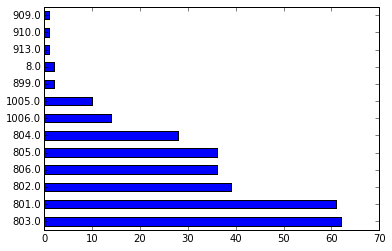

In [109]:
coreprocTop.FoR.value_counts().plot(kind='barh');

In [20]:
for f in set(coreprocTop.FoR.values):
    L=list(coreprocTop[coreprocTop.FoR==f].Acronym.value_counts().index)
    L.sort()
    print f,  ','.join(L)

801.0 AAAI,AAMAS,ACL,COLT,FOGA,ICAPS,ICCV,ICML,IEEE InfoVis,IJCAI,IJCAR,ISMAR,KR,NIPS,RSS,SIGGRAPH,UAI
802.0 CAV,FOCS,ISSAC,LICS,S&P,SODA,STOC
803.0 ACMMM,ASPLOS,CCS,HPCA,ICFP,ICSE,ISCA,OOPSLA,OSDI,PLDI,POPL,SIGCOMM,SOSP,USENIX-Security
804.0 CRYPTO,DCC,EuroCrypt,ICDE,ICDM,PODS,SIGKDD,SIGMOD,VLDB,WSDM
805.0 IEEE INFOCOM,PERCOM,PERVASIVE,PODC,UbiComp,WWW
806.0 CHI,ICIS,ISWC,JCDL ,SIGIR
1006.0 IPSN,MOBICOM,RTSS,SENSYS,SIGMETRICS


In [16]:
L=[]
print L.sort()

None


In [85]:
# Merge for conferences

conf = pd.merge(DF[DF.PublicationType=='conf'], coreprocTop[['FoR', 'NormalizedAcronym']], 
              how='inner',left_on='PublishedInDBLPCode', right_on='NormalizedAcronym')

jour = pd.merge(DF[DF.PublicationType=='journals'], corejourTop[['FoR', 'NormalizedAcronym']], 
              how='inner',left_on='PublishedInDBLPCode', right_on='NormalizedAcronym')

AstarCandJ= pd.concat([conf,jour])

print conf.shape, jour.shape, AstarCandJ.shape




(478803, 11) (278194, 11) (756997, 11)


In [103]:
AstarCandJ.pivot_table(index='Gender', columns='PublicationType', 
                       values='NrOfAuthors', 
                       aggfunc=len,
                       margins=True) # / len(AstarCandJ)

PublicationType,conf,journals,All
Gender,,,
female,82674.0,40767.0,123441.0
male,334959.0,188750.0,523709.0
unknown,61170.0,48677.0,109847.0
All,478803.0,278194.0,756997.0


In [104]:
AstarCandJ.to_pickle('Data/AstarCandJ.pkl')